## LDA 모형의 구조

* LDA(Latent Dirichlet Allocation) : 문서들이 쓰여질 때 그 문서를 구성하는 몇 개의 토픽이 존재하며 각 토픽은 단어의 집합으로 구성됐다고 가정. 내재된 토픽들을 유추하고자 하는 통계적 방법론

* 각 문서에 사용된 단어들의 빈도를 측정하고, 이로부터 역으로 모든 문서의 토픽분포와 각 토픽의 단어분포를 추정하는 것

* hyperparameter: 토픽의 개수(K)와 a(알파),b(베타)

* 성능 척도: 혼란도(perplexity), 토픽 응집도(topic coherence)

#### 혼란도(perplexity)

: 확률 모형이 실제 관측값을 얼마나 유사하게 예측해내는지 평가하고자 사용
: 값이 작을수록 토픽 모델이 문서집합을 잘 반영한다.

#### 토픽 응집도(topic coherence)

: 각 토픽에서 상위 비중을 차지하는 단어들이 의미적으로 유사한지 나타내는 척도
: 값이 클수록 유사한 단어들이 비중이 높음을 의미

#### 사용 패키지

1. 사이킷런
 - 혼란도 계산만 제공하고, 토픽 응집도는 지원하지 않음

2. gensim
 - 혼란도와 토픽 응집도 모두 지원

#  사이킷런을 이용한 토픽 모델링

### 데이터 준비

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 'comp.sys.ibm.pc.hardware', 'sci.crypt']

# 학습 데이터셋 가져오기
newsgroups_train = fetch_20newsgroups(subset = 'train', categories = categories)

print("Train set size:", len(newsgroups_train.data))
print("Selected categories:", newsgroups_train.target_names)

Train set size: 3219
Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern = "[\w']{3,}", stop_words = 'english',
                    max_features = 2000, min_df = 5, max_df = 0.5)
review_cv = cv.fit_transform(newsgroups_train.data)

### LDA 토픽 모델링 실행

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수로, 최적값을 찾아서 지정해주는 것이 중요하다.
                                max_iter=5, # 기본값은 10
                                topic_word_prior=0.1, # 베타를 말하며, 토픽의 사전 단어분포를 결정하는 매개변수, 기본값 1/n_components
                                doc_topic_prior=1.0, # 알파를 말하며, 문서의 사전 토픽분포를 결정하는 매개변수, 기본값 1/n_components
                                learning_method='online', # 'online'과 'batch'가 있으며, batch가 online에 비해 성능은 좋으나 느림 
                                n_jobs= -1, #사용 processor 수로, 기본값은 1, -1은 가능한 모든 프로세서를 사용함
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.901 0.007 0.011 0.009 0.007 0.008 0.022 0.008 0.007 0.022]
#Sum of topic weights of documents: [0.091 0.082 0.079 0.114 0.114 0.144 0.078 0.072 0.075 0.151]
#shape of topic word distribution: (10, 2000)


In [4]:
# 토픽별로 비중이 높은 상위 단어들을 찾아 순서대로 출력
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end = '')
        print(
        ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        )
        
# 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지를 출력해준다
    print()
    
print_top_words(lda,cv.get_feature_names_out(), 10)

Topic #0: com, article, keith, morality, sgi, think, sandvik, caltech, objective, moral
Topic #1: image, graphics, file, files, ftp, software, available, use, data, pub
Topic #2: space, access, com, net, digex, lunar, pat, science, posting, new
Topic #3: article, just, com, like, don't, university, i'm, henry, nntp, host
Topic #4: key, clipper, chip, encryption, com, government, keys, law, use, escrow
Topic #5: scsi, com, host, nntp, university, posting, thanks, know, bit, bus
Topic #6: nasa, space, gov, center, ___, orbit, washington, jpl, shuttle, earth
Topic #7: drive, com, disk, hard, controller, drives, dos, problem, tape, floppy
Topic #8: key, public, mail, university, message, faq, posting, pgp, des, group
Topic #9: god, people, don't, jesus, just, believe, say, does, think, know



* 위 결과에 대해 토픽이 제대로 분류됐는지 확인하는 것은 분석가의 역할로, 주관적 해석이 많이 반영된다.

### 최적의 토픽 수 선택하기

* 토픽 모델링에서 가장 중요한 하이퍼파라미터는 토픽의 수로, 이를 결정하기 위해 혼란도와 토픽 응집도를 계산하여 활용한다.

n_components: 6, perplexity: 1060.370
n_components: 7, perplexity: 1061.761
n_components: 8, perplexity: 1016.386
n_components: 9, perplexity: 1015.849
n_components: 10, perplexity: 1030.698
n_components: 11, perplexity: 1028.851
n_components: 12, perplexity: 1026.104
n_components: 13, perplexity: 1037.293
n_components: 14, perplexity: 1039.847
n_components: 15, perplexity: 1050.649


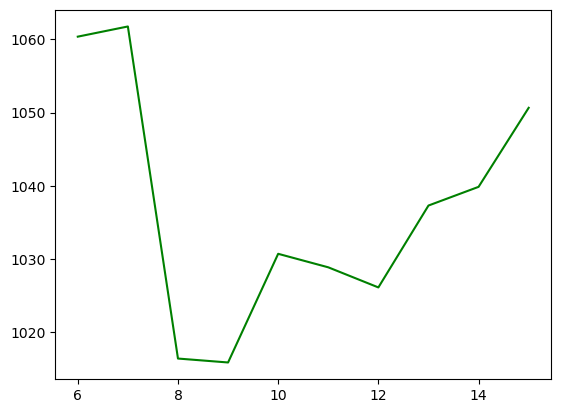

n_components with minimum perplexity: 9


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start = 10, end = 30, max_iter = 5, topic_word_prior = 0.1, doc_topic_prior = 1.0):
    iter_num = []
    per_value = []
    
    for i in range(start, end+1):
        lda = LatentDirichletAllocation(n_components = i, max_iter = max_iter, 
                                       topic_word_prior = topic_word_prior,
                                       doc_topic_prior = doc_topic_prior,
                                       learning_method = 'batch',
                                       n_jobs = -1,
                                       random_state = 7)
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:.3f}')
        
    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:",
     show_perplexity(review_cv, start = 6, end = 15))

In [6]:
lda = LatentDirichletAllocation(n_components = 8, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: image, graphics, mail, available, file, ftp, data, files, software, information
Topic #1: nasa, gov, posting, university, host, nntp, space, ___, center, distribution
Topic #2: com, keith, article, morality, posting, nntp, host, think, caltech, sgi
Topic #3: com, article, jesus, know, just, don't, posting, god, host, i'm
Topic #4: people, god, does, don't, think, say, believe, just, way, like
Topic #5: drive, scsi, card, com, disk, thanks, ide, controller, bus, hard
Topic #6: space, access, article, launch, year, just, like, digex, com, moon
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



# gensim을 이용한 토픽 모델링

### Gensim 사용법과 시각화

In [7]:
!pip install --upgrade gensim

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

cachedStopWords = stopwords.words("english")

RegTok = RegexpTokenizer("[\w']{3,}") # 정규포현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) #영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

In [9]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


In [10]:
from gensim.models import LdaModel

num_topics = 10
passes = 5 # 사이킷런의 max_iter와 같은 의미
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics,\
                       random_state=7)

# 이 밖에도 여러 변수가 존재함
# alpha는 문서의 사전 토픽분포에 대한 매개변수로, 사전 토픽분포를 직접 지정하거나 토픽분포를 결정하는 전략을 지정할 수 있음
# 전략은 symmetric(모든 토픽에 대해 고정된 대칭 값을 사용), asymmetric(토픽들에 대해 비대칭 값을 사용), auto(비대칭 값을 corpus로부터 학습) 중 선택 
# eta는 토픽의 사전 단어분포에 대한 매개변수로, 직접 분포를 주거나 alpha와 같이 auto로 전략을 지정할 수 있음

CPU times: total: 6.25 s
Wall time: 6.26 s


In [11]:
model.print_topics(num_words = 10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

* print_topics()를 통해 각 토픽의 번호와 함께 토픽의 상위 비중 단어, 비중을 함께 볼 수 있음

In [12]:
print("#topic distribution of the first document:", model.get_document_topics(corpus)[0])
# 첫 번째 문서에 대한 토픽 분포를 보여준다.

#topic distribution of the first document: [(0, 0.72576934), (8, 0.2699505)]


In [13]:
!pip install --user pyLDAvis

In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# LDA 모형을 pyLDAvis 객체에 전달
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.655416
5      0.065990  0.123620       2        1  14.522776
9      0.072133  0.092872       3        1  12.987437
7      0.138320  0.043609       4        1  11.020437
4     -0.021828  0.007495       5        1   9.298365
6      0.072783 -0.094709       6        1   9.118869
3      0.027374 -0.054949       7        1   8.494165
0     -0.040786 -0.129974       8        1   4.524071
2      0.005359 -0.091972       9        1   4.051827
1     -0.182144  0.063761      10        1   3.326637, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3752.000000  3752.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.445774  1672.571326  Topic10  -5.1558   0.1469
789          sci    53.265337   309.474053  Topic10  -5.3463   1.6436
602   university    56.862740  1487.218103  Topic10  -5.2810   0.1392
294         time    55.767882  1187.715297  Topic10  -5.3004   0.3446
315       better    54.193100   564.543676  Topic10  -5.3290   1.0597

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006274      128
1359      2  0.069013      128
1359      3  0.037643      128
1359      4  0.878342      128
153       1  0.057463     1993
...     ...       ...      ...
343       8  0.022394    years
343       9  0.005599    years
343      10  0.121303    years
704       3  0.991487      zoo
705       3  0.984036  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

### 혼란도와 토픽 응집도를 이용한 최적값 선택

* 혼란도: log_perplexity()로 구할수 있음. corpus를 인수로 넘겨줘야 함

* 토픽 응집도: model, corpus 등의 척도를 지정해야 함
* 토픽 응집도에서 u_mass를 사용할 때는 model과 corpus를 반드시 지정해야 하고, c로 시작하는 척도를 사용할 때는 model과 texts가 반드시 필요하다.

In [15]:
from gensim.models import CoherenceModel
cm = CoherenceModel(model = model, corpus = corpus, coherence = 'u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


num_topics: 6, perplexity: -7.035, coherence: -1.701
num_topics: 7, perplexity: -7.023, coherence: -1.735
num_topics: 8, perplexity: -7.023, coherence: -1.547
num_topics: 9, perplexity: -7.007, coherence: -1.891
num_topics: 10, perplexity: -6.996, coherence: -1.888
num_topics: 11, perplexity: -7.027, coherence: -2.164
num_topics: 12, perplexity: -7.019, coherence: -2.018
num_topics: 13, perplexity: -7.025, coherence: -2.255
num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


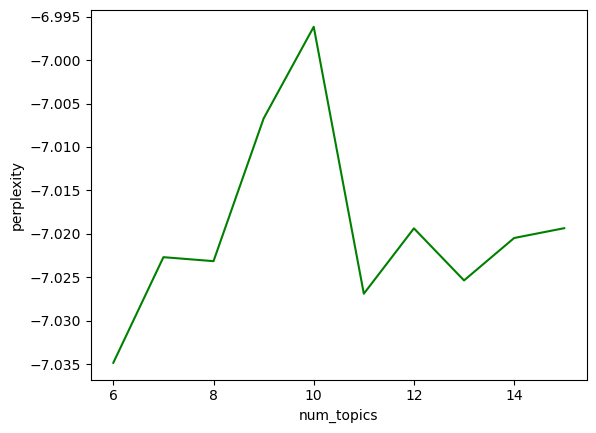

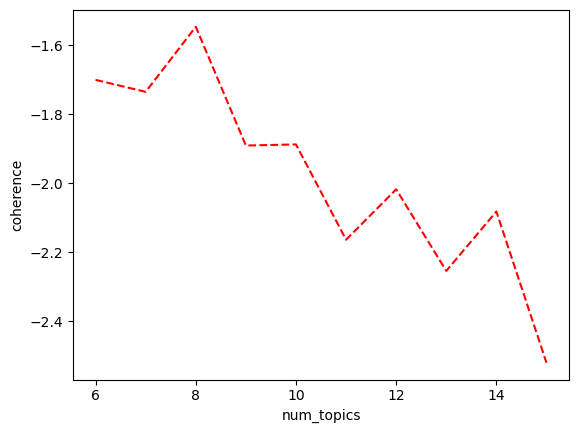

In [16]:
def show_coherence(corpus, dictionary, start = 6, end = 15):
    iter_num = []
    per_value = []
    coh_value = []
    
    for i in range(start, end +1):
        model = LdaModel(corpus= corpus, id2word = dictionary,
                        chunksize = 1000, num_topics = i,
                        random_state = 7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model = model, corpus = corpus, coherence = 'u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')
        
    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()
    
    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()
    
show_coherence(corpus, dictionary, start = 6, end = 15)

* 위의 결과를 보면, 혼란도는 토픽 수가 6일때 가장 좋은 반면, 토픽 응집도는 토픽 수가 8일 때 가장 좋다.

### 토픽트렌드로 시간에 따른 주제의 변화 알아내기

1: https://github.com/akngs/petitions

In [17]:
!pip install wget

import os
import wget
import ssl

data_dir = 'data'
url = 'https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition_sampled.csv'
ssl._create_default_https_context = ssl._create_unverified_context

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

wget.download(url, data_dir)

100% [........................................................................] 24480914 / 24480914

'data/petition_sampled (1).csv'

In [18]:
import pandas as pd

df = pd.read_csv("./data/petition_sampled.csv") #read data
df.iloc[[2]]

,article_id,start,end,answered,votes,category,title,content
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...


In [19]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer = tokenizer,
                     max_df = 0.5, min_df = 5,
                     max_features = 1000)

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

(18077, 1000)


In [26]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 15, \
                                n_jobs = -1, \
                                random_state = 0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end = '')
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words -1:-1]]))
print_top_words(lda,vec.get_feature_names_out(), 15)

CPU times: total: 703 ms
Wall time: 3.67 s
Topic #0: 사람, 생각, 피해자, 사건, 병원, 대통령, 정말, 국민, 가족, 가해자, 환자, 나라, 자신, 처벌, 지금
Topic #1: 북한, 우리, 한국, 대통령, 정부, 국민, 대한민국, 미국, 문재인, 일본, 국가, 나라, 생각, 문제, 우리나라
Topic #2: 아이, 부모, 생각, 어린이집, 엄마, 교사, 우리, 유치원, 자녀, 가정, 동물, 출산, 가족, 결혼, 저희
Topic #3: 청소년, 불법, 폐지, 보호, 장애인, 조직, 사찰, 게임, 생각, 외국인, 이용, 나이, 사회, 범죄, 축구
Topic #4: 정부, 주택, 정책, 부동산, 서민, 아파트, 국민, 세금, 나라, 대통령, 지금, 사람, 투기, 집값, 임대
Topic #5: 일자리, 기업, 생각, 근무, 정부, 지원, 근로자, 임금, 시간, 최저임금, 정책, 직원, 사람, 고용, 대기업
Topic #6: 국민, 청원, 국회의원, 국회, 의원, 세금, 반대, 청와대, 생각, 대통령, 정치, 동의, 제도, 나라, 난민
Topic #7: 내용, 대한, 조사, 관리, 판결, 관련, 사실, 공사, 업무, 판사, 확인, 사건, 기관, 해당, 결과
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 선생님, 교사, 문제, 시간, 고등학교, 제도, 위해
Topic #9: 보험, 연금, 국민연금, 공무원, 국민, 방송, 지급, 소득, 가입, 국가, 군인, 보험료, 기초, 의무, 제도
Topic #10: 여성, 사회, 공무원, 생각, 대한민국, 사람, 남성, 남자, 여자, 행정, 나라, 의무, 군대, 국민, 국가
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 대한민국, 조직, 불법, 수사, 만행, 경찰서, 범죄자, 부정부패, 증거, 살인마
Topic #12: 처벌, 차량, 사고, 경우, 안전, 피해자, 피해, 범죄, 기사, 사건, 대한, 행위, 택시, 이명박, 운전
Topic #13: 

* 토픽별 상위 15개 단어를 살펴보면, 어떤 토픽은 두 개 이상의 토픽이 섞여 있는 것으로 보인다.

In [27]:
# 토픽 트렌드를 찾기 위해서는 각 문서의 날짜(start)와 토픽 분포를 결합해야 한다.
# 날짜에서 연도와 월만 잘라 가져온다.
trend_data = pd.DataFrame(pet_topics, columns = ['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis = 1)
trend_data.iloc[:5, -5:]

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.495397,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.000227,2017-08
4,0.000447,0.061049,0.000447,0.000447,2017-08


In [28]:
# groupby()를 이용해 월별 평균을 구한다.
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, -5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.033960,0.017952,0.024384,0.029802,0.101626
2017-09,0.045371,0.023622,0.072277,0.020161,0.040465
2017-10,0.088079,0.055008,0.058133,0.032353,0.096818
2017-11,0.046716,0.044052,0.224816,0.040936,0.048950
2017-12,0.061058,0.028460,0.071439,0.054063,0.079466


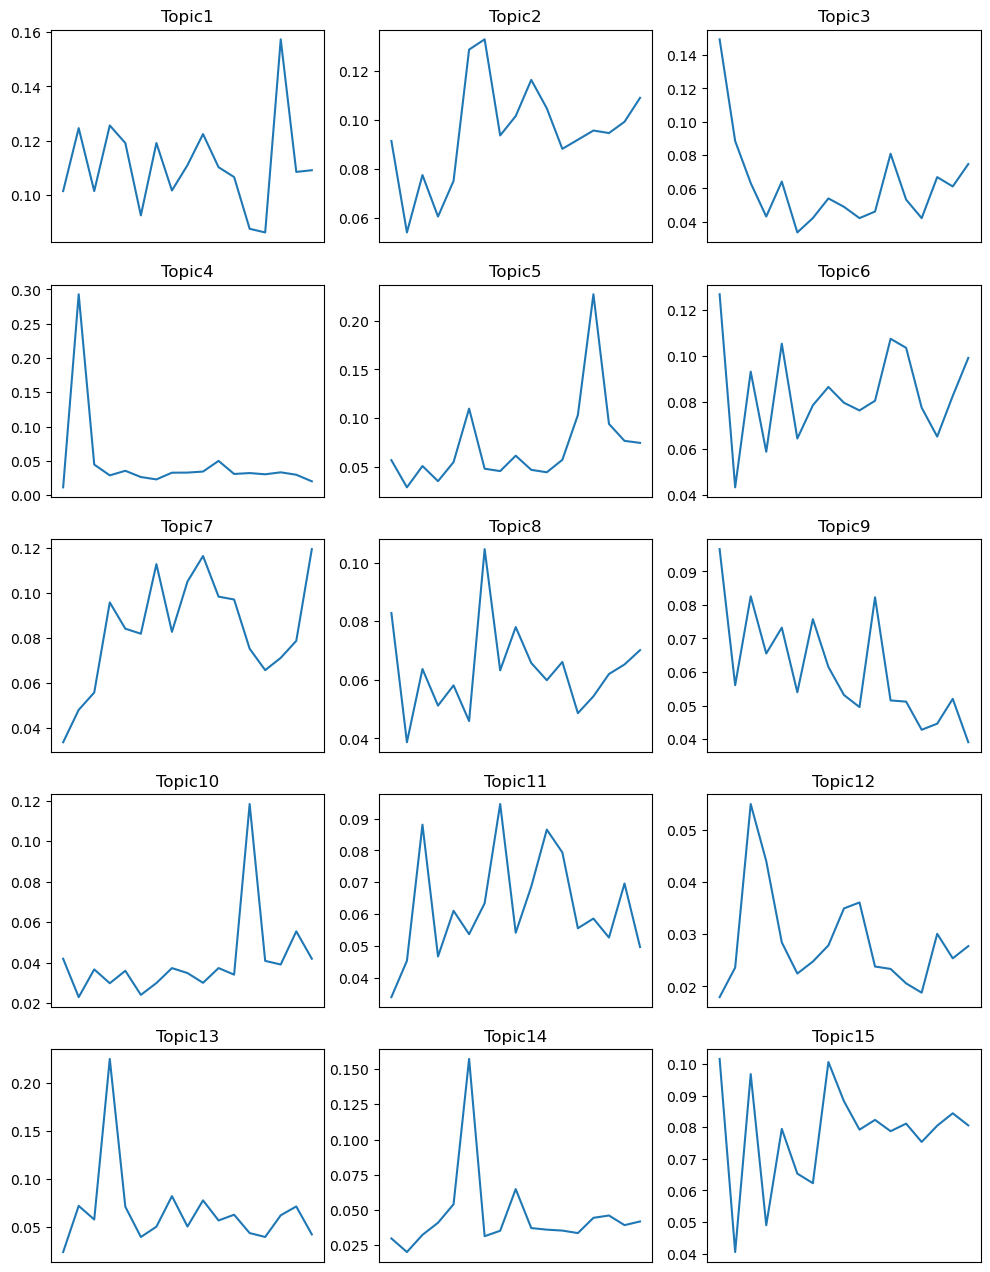

In [25]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex = 'col', figsize = (12,16))
for col, ax in zip(trend.columns.tolist(), axes.ravel()):
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()

* Topic 3, 4, 9, 13과 같이 초기에 비중이 높았다가 뒤로 가면서 점차 줄어드는 주제를 Cold Topic이라 부르고,
* Topic 5, 15와 같이 뒤로 가면서 비중이 높아지는 주제를 Hot Topic이라고 한다.
> 연구주제의 변화 및 트렌드를 파악하는 데에 도움이 될 수 있다. 